# Analisi dati CICO

In [54]:
# SettingWithCopyWarning
# Disable 
pd.options.mode.chained_assignment = None 
# Enable 
#pd.options.mode.chained_assignment = 'warn'

In [4]:
# Install required package 'pymysql' (if not already installed)
import pip

def import_or_install(pymysql):
    try:
        __import__(pymysql)
    except ImportError:
        pip.main(['install', pymysql])    
#!pip install pymysql

In [2]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.stata import StataReader
import pymysql
import mysql.connector
from mysql.connector import Error
from mysql.connector import errorcode

In [37]:
# Import data from my computer in STATA format
df_stata = pd.read_stata('C:/Users/Nicola Caravaggio/OneDrive/Desktop/Ciu_Tos_Roma3/CICO/cico_02-10-19.dta')

In [5]:
# Connection to mySQL database "prova_cico"
try:
    connection = mysql.connector.connect(host='127.0.0.1',
                                         database='prova_cico',
                                         user='root',
                                         password='050590')

    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("Your connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  8.0.16
Your connected to database:  ('prova_cico',)


In [6]:
# Example, show the first 5 rows of the database
df = pd.read_sql_query("SELECT * FROM data_cico LIMIT 5",
    connection) 
print ('Query correctly read')
df

Query correctly read


cfdatore_crip                 cflavoratore_crip  \
0  \n48D49BDAC8D8F2B2D63A6122F2B4D332  4C30B254455CDB5FF6E53857746D633E   
1  \n90FF9B696EC2BD0419792F33FA3EBCEE  4CC0E3D4A897A6661D35D4D30D07F57A   
2  \nD23485B84D16E0F9CCDB7B7F013B4F76  57E6FA30170F062738665433915DEAFD   
3  \n182D316EB9A78C40E0CF5A2D5C25056C  49AF87408CC71FBB51C01D6D0C90BC3B   
4  \n90D5C65C1557742DBE2808A10956456D  64D130D252AE4739EC6D7EF9197D76DE   

  rapporto_datainizio  annoattivazione  annonascita codgenere regione_nascita  \
0           06jul2017             2017         1953   Femmina        Campania   
1           01dec2011             2011         1988   Maschio         Sicilia   
2           22apr2015             2015         1960   Femmina        Campania   
3           01aug2016             2016         1990   Maschio          Estero   
4           01jun2011             2011         1970   Maschio          Estero   

  codcittadinanza  codtitolostudio codregionedomicilio  ...  codagevolazione  \
0          Italia               20            Campania  ...              999   
1          Italia               70             Sicilia  ...              999   
2          Italia               10            Campania  ...              999   
3        Extra UE               40              Veneto  ...              999   
4        Extra UE                0            Campania  ...              999   

  idsociolavoratore dtcessazioneeffettiva  codmotivocessazioneco  \
0                No             10jul2017                    254   
1                No             31mar2012                    254   
2                No             30jun2015                    254   
3                No             22jan2018                     10   
4                No             31jan2012                     12   

  dtfineprevista dttrasformazione  codtipotrasformazione  numeroproroghe  \
0      10jul2017                                                       0   
1      31mar2012                                                       0   
2      30jun2015                                                       0   
3                                                                      0   
4                                                                      0   

  coef_uni id  
0        8  1  
1        8  2  
2        8  3  
3        5  4  
4        5  5  

[5 rows x 27 columns]

In [7]:
# Count number of 'attivazioni' between 2010 and 2018
df = pd.read_sql_query("SELECT annoattivazione, COUNT(*) as 'Numero attivazioni' FROM data_cico GROUP BY annoattivazione \
                        HAVING annoattivazione >= 2010 \
                        ORDER BY annoattivazione DESC;",
    connection)
print ('Query correctly read')
df

Query correctly read


annoattivazione  Numero attivazioni
0             2018             1628286
1             2017             1528161
2             2016             1349264
3             2015             1477731
4             2014             1406010
5             2013             1352587
6             2012             1438580
7             2011             1464604
8             2010             1428553

## Tavola 1
### *Attivazioni in Italia nel settore terziario per singolo CCNL e per anno (valori percentuali)*

In [8]:
# Count the amount of 'attivazioni' for each year from 2009 to 2018 (with and without weights) in 'settore terziario'
df = pd.read_sql_query("""SELECT annoattivazione as 'Anno',
COUNT(*) as 'Numero attivazioni totali',
SUM(coef_uni) as 'Numero attivazioni totali (con pesi)',
SUM(case when codccnl = 48 then coef_uni else 0 end) as `Settore 48 (pes.)`,
SUM(case when codccnl = 49 then coef_uni else 0 end) as `Settore 49 (pes.)`,
SUM(case when codccnl = 50 then coef_uni else 0 end) as `Settore 50 (pes.)`,
SUM(case when codccnl = 51 then coef_uni else 0 end) as `Settore 51 (pes.)`,
SUM(case when codccnl = 53 then coef_uni else 0 end) as `Settore 53 (pes.)`,
SUM(case when codccnl = 54 then coef_uni else 0 end) as `Settore 54 (pes.)`,
SUM(case when codccnl = 55 then coef_uni else 0 end) as `Settore 55 (pes.)`,
SUM(case when codccnl = 56 then coef_uni else 0 end) as `Settore 56 (pes.)`
FROM data_cico 
WHERE 
codccnl in (48,49,50,51,53,54,55,56)
AND codregionelavoro != 'Estero' 
AND codprovincialavoro != 999
AND codcittadinanza != 'N.D.'
AND codsettore != '999' 
AND codtipocontratto != 99
GROUP BY annoattivazione
HAVING annoattivazione >= 2009 
ORDER BY annoattivazione DESC;""",
connection)
print ('Query correctly read')
df

Query correctly read


Anno  Numero attivazioni totali  Numero attivazioni totali (con pesi)  \
0  2018                     152596                             1159454.0   
1  2017                     143795                             1094996.0   
2  2016                     123729                              943156.0   
3  2015                     143516                             1097356.0   
4  2014                     129336                              987990.0   
5  2013                     115422                              881692.0   
6  2012                     133992                             1023454.0   
7  2011                     139612                             1069558.0   
8  2010                     139164                             1070401.0   
9  2009                     128172                              987835.0   

   Settore 48 (pes.)  Settore 49 (pes.)  Settore 50 (pes.)  Settore 51 (pes.)  \
0          1062993.0            40231.0             1306.0            16789.0   
1           996177.0            43117.0             1344.0            15365.0   
2           854702.0            39900.0             1012.0            12658.0   
3           996608.0            42222.0             1263.0            14648.0   
4           895994.0            39466.0             1189.0            11574.0   
5           789853.0            41571.0             1016.0            10617.0   
6           911974.0            49664.0             1557.0            11525.0   
7           961659.0            47104.0             1713.0            11279.0   
8           957268.0            51742.0             1853.0            12018.0   
9           882794.0            42933.0             1581.0            12169.0   

   Settore 53 (pes.)  Settore 54 (pes.)  Settore 55 (pes.)  Settore 56 (pes.)  
0             1257.0            32822.0             2519.0             1537.0  
1             1257.0            32218.0             3610.0             1908.0  
2             1049.0            29716.0             2227.0             1892.0  
3             1109.0            34731.0             4317.0             2458.0  
4             1190.0            31195.0             5003.0             2379.0  
5             1006.0            30492.0             4375.0             2762.0  
6             1500.0            38685.0             5753.0             2796.0  
7             1125.0            37195.0             6351.0             3132.0  
8             1201.0            36929.0             6338.0             3052.0  
9             1280.0            37704.0             6393.0             2981.0

In [9]:
# Add 'Totale attivazioni terziario (pes.)'
df['Totale attivazioni terziario (pes.)'] = df.iloc[:, 3:10].sum(axis=1)

In [10]:
# Generate a new dataframe with percentage values
terz = (df.iloc[:,3:].div(df['Totale attivazioni terziario (pes.)'], axis = 0))*100

In [11]:
# Add the columns for years
terz.insert(0, "Anno", ['2018','2017','2016','2015','2014','2013','2012','2011','2010','2009'], True) 
#terz.insert(0, "Anno", [2018,2017,2016,2015,2014,2013,2012,2011,2010,2009], True) 

In [12]:
# Add again 'Totale attivazioni terziario (migliaia, pes.)', not as percentage
terz['Totale attivazioni terziario (migliaia, pes.)'] = df.iloc[:,11]

In [13]:
# Show the new generated dataframe
terz

Anno  Settore 48 (pes.)  Settore 49 (pes.)  Settore 50 (pes.)  \
0  2018          91.802176           3.474429           0.112789   
1  2017          91.134200           3.944513           0.122954   
2  2016          90.803643           4.238981           0.107515   
3  2015          91.022908           3.856250           0.115353   
4  2014          90.907468           4.004217           0.120636   
5  2013          89.865291           4.729728           0.115595   
6  2012          89.351575           4.865881           0.152549   
7  2011          90.175877           4.416997           0.160630   
8  2010          89.686504           4.847711           0.173608   
9  2009          89.637043           4.359326           0.160531   

   Settore 51 (pes.)  Settore 53 (pes.)  Settore 54 (pes.)  Settore 55 (pes.)  \
0           1.449931           0.108557           2.834573           0.217546   
1           1.405651           0.114995           2.947430           0.330257   
2           1.344787           0.111446           3.157031           0.236597   
3           1.337842           0.101288           3.172076           0.394283   
4           1.174297           0.120737           3.165042           0.507604   
5           1.207946           0.114457           3.469218           0.497764   
6           1.129174           0.146964           3.790202           0.563656   
7           1.057645           0.105493           3.487818           0.595541   
8           1.125967           0.112522           3.459881           0.593808   
9           1.235615           0.129969           3.828385           0.649132   

   Settore 56 (pes.)  Totale attivazioni terziario (pes.)  \
0           0.132738                                100.0   
1           0.174551                                100.0   
2           0.201006                                100.0   
3           0.224496                                100.0   
4           0.241373                                100.0   
5           0.314246                                100.0   
6           0.273941                                100.0   
7           0.293691                                100.0   
8           0.285942                                100.0   
9           0.302684                                100.0   

   Totale attivazioni terziario (migliaia, pes.)  
0                                      1157917.0  
1                                      1093088.0  
2                                       941264.0  
3                                      1094898.0  
4                                       985611.0  
5                                       878930.0  
6                                      1020658.0  
7                                      1066426.0  
8                                      1067349.0  
9                                       984854.0

In [14]:
# Transpose the dataframe
terz_transposed = terz.T

In [15]:
# Set the rows of years as header
terz_transposed.columns = terz_transposed.iloc[0]
terz_transposed.drop('Anno', inplace=True)

In [16]:
terz_transposed

Anno                                                  2018         2017  \
Settore 48 (pes.)                                  91.8022      91.1342   
Settore 49 (pes.)                                  3.47443      3.94451   
Settore 50 (pes.)                                 0.112789     0.122954   
Settore 51 (pes.)                                  1.44993      1.40565   
Settore 53 (pes.)                                 0.108557     0.114995   
Settore 54 (pes.)                                  2.83457      2.94743   
Settore 55 (pes.)                                 0.217546     0.330257   
Settore 56 (pes.)                                 0.132738     0.174551   
Totale attivazioni terziario (pes.)                    100          100   
Totale attivazioni terziario (migliaia, pes.)  1.15792e+06  1.09309e+06   

Anno                                               2016        2015      2014  \
Settore 48 (pes.)                               90.8036     91.0229   90.9075   
Settore 49 (pes.)                               4.23898     3.85625   4.00422   
Settore 50 (pes.)                              0.107515    0.115353  0.120636   
Settore 51 (pes.)                               1.34479     1.33784    1.1743   
Settore 53 (pes.)                              0.111446    0.101288  0.120737   
Settore 54 (pes.)                               3.15703     3.17208   3.16504   
Settore 55 (pes.)                              0.236597    0.394283  0.507604   
Settore 56 (pes.)                              0.201006    0.224496  0.241373   
Totale attivazioni terziario (pes.)                 100         100       100   
Totale attivazioni terziario (migliaia, pes.)    941264  1.0949e+06    985611   

Anno                                               2013         2012  \
Settore 48 (pes.)                               89.8653      89.3516   
Settore 49 (pes.)                               4.72973      4.86588   
Settore 50 (pes.)                              0.115595     0.152549   
Settore 51 (pes.)                               1.20795      1.12917   
Settore 53 (pes.)                              0.114457     0.146964   
Settore 54 (pes.)                               3.46922       3.7902   
Settore 55 (pes.)                              0.497764     0.563656   
Settore 56 (pes.)                              0.314246     0.273941   
Totale attivazioni terziario (pes.)                 100          100   
Totale attivazioni terziario (migliaia, pes.)    878930  1.02066e+06   

Anno                                                  2011         2010  \
Settore 48 (pes.)                                  90.1759      89.6865   
Settore 49 (pes.)                                    4.417      4.84771   
Settore 50 (pes.)                                  0.16063     0.173608   
Settore 51 (pes.)                                  1.05764      1.12597   
Settore 53 (pes.)                                 0.105493     0.112522   
Settore 54 (pes.)                                  3.48782      3.45988   
Settore 55 (pes.)                                 0.595541     0.593808   
Settore 56 (pes.)                                 0.293691     0.285942   
Totale attivazioni terziario (pes.)                    100          100   
Totale attivazioni terziario (migliaia, pes.)  1.06643e+06  1.06735e+06   

Anno                                               2009  
Settore 48 (pes.)                                89.637  
Settore 49 (pes.)                               4.35933  
Settore 50 (pes.)                              0.160531  
Settore 51 (pes.)                               1.23561  
Settore 53 (pes.)                              0.129969  
Settore 54 (pes.)                               3.82838  
Settore 55 (pes.)                              0.649132  
Settore 56 (pes.)                              0.302684  
Totale attivazioni terziario (pes.)                 100  
Totale attivazioni terziario (migliaia, pes.)    984854

In [17]:
# Change rows' index
terz_transposed = terz_transposed.rename(index={'Settore 48 (pes.)': 'CCNL distribuzione e servizi',
                                                'Settore 49 (pes.)': 'CCNL cooperative di consumo e loro consorzi',
                                                'Settore 50 (pes.)': 'CCNL dipendenti farmacie municipalizzate',
                                                'Settore 51 (pes.)': 'CCNL dipendenti farmacie private',
                                                'Settore 53 (pes.)': 'Lavorazione e commercio fiori',
                                                'Settore 54 (pes.)': 'Piccole aziende commerciali',
                                                'Settore 55 (pes.)': 'Cooperative di consumo',
                                                'Settore 56 (pes.)': 'Agenti e rappresentanti'
                                               })

In [18]:
# Revert the columns' order
tavola_1 = terz_transposed[terz_transposed.columns[::-1]]

In [19]:
# The final table
tavola_1

Anno                                               2009         2010  \
CCNL distribuzione e servizi                     89.637      89.6865   
CCNL cooperative di consumo e loro consorzi     4.35933      4.84771   
CCNL dipendenti farmacie municipalizzate       0.160531     0.173608   
CCNL dipendenti farmacie private                1.23561      1.12597   
Lavorazione e commercio fiori                  0.129969     0.112522   
Piccole aziende commerciali                     3.82838      3.45988   
Cooperative di consumo                         0.649132     0.593808   
Agenti e rappresentanti                        0.302684     0.285942   
Totale attivazioni terziario (pes.)                 100          100   
Totale attivazioni terziario (migliaia, pes.)    984854  1.06735e+06   

Anno                                                  2011         2012  \
CCNL distribuzione e servizi                       90.1759      89.3516   
CCNL cooperative di consumo e loro consorzi          4.417      4.86588   
CCNL dipendenti farmacie municipalizzate           0.16063     0.152549   
CCNL dipendenti farmacie private                   1.05764      1.12917   
Lavorazione e commercio fiori                     0.105493     0.146964   
Piccole aziende commerciali                        3.48782       3.7902   
Cooperative di consumo                            0.595541     0.563656   
Agenti e rappresentanti                           0.293691     0.273941   
Totale attivazioni terziario (pes.)                    100          100   
Totale attivazioni terziario (migliaia, pes.)  1.06643e+06  1.02066e+06   

Anno                                               2013      2014        2015  \
CCNL distribuzione e servizi                    89.8653   90.9075     91.0229   
CCNL cooperative di consumo e loro consorzi     4.72973   4.00422     3.85625   
CCNL dipendenti farmacie municipalizzate       0.115595  0.120636    0.115353   
CCNL dipendenti farmacie private                1.20795    1.1743     1.33784   
Lavorazione e commercio fiori                  0.114457  0.120737    0.101288   
Piccole aziende commerciali                     3.46922   3.16504     3.17208   
Cooperative di consumo                         0.497764  0.507604    0.394283   
Agenti e rappresentanti                        0.314246  0.241373    0.224496   
Totale attivazioni terziario (pes.)                 100       100         100   
Totale attivazioni terziario (migliaia, pes.)    878930    985611  1.0949e+06   

Anno                                               2016         2017  \
CCNL distribuzione e servizi                    90.8036      91.1342   
CCNL cooperative di consumo e loro consorzi     4.23898      3.94451   
CCNL dipendenti farmacie municipalizzate       0.107515     0.122954   
CCNL dipendenti farmacie private                1.34479      1.40565   
Lavorazione e commercio fiori                  0.111446     0.114995   
Piccole aziende commerciali                     3.15703      2.94743   
Cooperative di consumo                         0.236597     0.330257   
Agenti e rappresentanti                        0.201006     0.174551   
Totale attivazioni terziario (pes.)                 100          100   
Totale attivazioni terziario (migliaia, pes.)    941264  1.09309e+06   

Anno                                                  2018  
CCNL distribuzione e servizi                       91.8022  
CCNL cooperative di consumo e loro consorzi        3.47443  
CCNL dipendenti farmacie municipalizzate          0.112789  
CCNL dipendenti farmacie private                   1.44993  
Lavorazione e commercio fiori                     0.108557  
Piccole aziende commerciali                        2.83457  
Cooperative di consumo                            0.217546  
Agenti e rappresentanti                           0.132738  
Totale attivazioni terziario (pes.)                    100  
Totale attivazioni terziario (migliaia, pes.)  1.15792e+06

## Figura 1
### *Incidenza % delle attivazioni con i CCNL Terziario sul totale delle attivazioni nel settore privato in Italia per anno e per ripartizione geografica, con dettaglio della regione Lazio (anni 2009-2018)*

In [25]:
# Count the amount of 'attivazioni' for each year from 2009 to 2018 (with and without weights) in 'settore terziario' 
# divided by regions with a specific focus for Lazio
df2 = pd.read_sql_query("""SELECT annoattivazione as 'Anno',
COUNT(*) as 'Numero attivazioni totali',
SUM(coef_uni) as 'Numero attivazioni totali (con pesi)',
SUM(case when codregionelavoro in('Bolzano','Emilia Romagna','Friuli Venezia Giulia','Trento','Veneto') then coef_uni else 0 end) as `Nord est`,
SUM(case when codregionelavoro in('Liguria','Lombardia','Piemonte','Val d''Aosta') then coef_uni else 0 end) as `Nord ovest`,
SUM(case when codregionelavoro in('Lazio','Marche','Toscana','Umbria') then coef_uni else 0 end) as `Centro`,
SUM(case when codregionelavoro = 'Lazio' then coef_uni else 0 end) as `Lazio`,
SUM(case when codregionelavoro in('Sardegna','Sicilia') then coef_uni else 0 end) as `Isole`,
SUM(case when codregionelavoro in('Abruzzo','Basilicata','Calabria','Campania','Molise','Puglia') then coef_uni else 0 end) as `Sud`
FROM data_cico 
WHERE 
codccnl in (48,49,50,51,53,54,55,56)
AND codregionelavoro != 'Estero' 
AND codprovincialavoro != 999
AND codcittadinanza != 'N.D.'
AND codsettore != '999' 
AND codtipocontratto != 99
GROUP BY annoattivazione
HAVING annoattivazione >= 2009 
ORDER BY annoattivazione DESC;""",
connection)
print ('Query correctly read')
df2

Query correctly read


Anno  Numero attivazioni totali  Numero attivazioni totali (con pesi)  \
0  2018                     152596                             1159454.0   
1  2017                     143795                             1094996.0   
2  2016                     123729                              943156.0   
3  2015                     143516                             1097356.0   
4  2014                     129336                              987990.0   
5  2013                     115422                              881692.0   
6  2012                     133992                             1023454.0   
7  2011                     139612                             1069558.0   
8  2010                     139164                             1070401.0   
9  2009                     128172                              987835.0   

   Nord est  Nord ovest    Centro     Lazio    Isole       Sud  
0  227401.0    346402.0  240061.0  139497.0  86920.0  258670.0  
1  213113.0    331502.0  228132.0  128756.0  81685.0  240564.0  
2  174704.0    298883.0  191227.0  111087.0  72890.0  205452.0  
3  195831.0    336379.0  233908.0  137220.0  84402.0  246836.0  
4  171595.0    325040.0  197586.0  107179.0  77935.0  215834.0  
5  166461.0    269663.0  188406.0  100706.0  72288.0  184874.0  
6  195693.0    310947.0  219298.0  115685.0  86037.0  211479.0  
7  211773.0    347433.0  233863.0  125672.0  80815.0  195674.0  
8  202059.0    359111.0  238029.0  131757.0  84395.0  186807.0  
9  192040.0    325561.0  220264.0  119119.0  78320.0  171650.0

In [27]:
# The same as before but considering all 'attivazioni' in the Italian private sector
df_all = pd.read_sql_query("""SELECT annoattivazione as 'Anno',
COUNT(*) as 'Numero attivazioni totali',
SUM(coef_uni) as 'Numero attivazioni totali (con pesi)',
SUM(case when codregionelavoro in('Bolzano','Emilia Romagna','Friuli Venezia Giulia','Trento','Veneto') then coef_uni else 0 end) as `Nord est`,
SUM(case when codregionelavoro in('Liguria','Lombardia','Piemonte','Val d''Aosta') then coef_uni else 0 end) as `Nord ovest`,
SUM(case when codregionelavoro in('Lazio','Marche','Toscana','Umbria') then coef_uni else 0 end) as `Centro`,
SUM(case when codregionelavoro = 'Lazio' then coef_uni else 0 end) as `Lazio`,
SUM(case when codregionelavoro in('Sardegna','Sicilia') then coef_uni else 0 end) as `Isole`,
SUM(case when codregionelavoro in('Abruzzo','Basilicata','Calabria','Campania','Molise','Puglia') then coef_uni else 0 end) as `Sud`
FROM data_cico 
WHERE 
codregionelavoro != 'Estero' 
AND codprovincialavoro != 999
AND codcittadinanza != 'N.D.'
AND codsettore != '999' 
AND codtipocontratto != 99
GROUP BY annoattivazione
HAVING annoattivazione >= 2009 
ORDER BY annoattivazione DESC;""",
connection)
print ('Query correctly read')
df_all

Query correctly read


Anno  Numero attivazioni totali  Numero attivazioni totali (con pesi)  \
0  2018                    1627739                            11984155.0   
1  2017                    1527629                            11299255.0   
2  2016                    1348715                             9993277.0   
3  2015                    1477128                            11013226.0   
4  2014                    1405439                            10498838.0   
5  2013                    1352132                            10096176.0   
6  2012                    1438238                            10749594.0   
7  2011                    1464222                            10957782.0   
8  2010                    1428128                            10712815.0   
9  2009                    1376925                            10263793.0   

    Nord est  Nord ovest     Centro      Lazio      Isole        Sud  
0  2324997.0   2580110.0  2807166.0  1653923.0  1179350.0  3092532.0  
1  2177492.0   2396803.0  2625281.0  1553551.0  1134802.0  2964877.0  
2  1840102.0   2123604.0  2370197.0  1453111.0  1032967.0  2626407.0  
3  1984838.0   2312871.0  2680403.0  1655495.0  1153742.0  2881372.0  
4  1904979.0   2152070.0  2495337.0  1517630.0  1158539.0  2787913.0  
5  1839482.0   2064000.0  2381320.0  1429025.0  1127969.0  2683405.0  
6  1983590.0   2257193.0  2500377.0  1470891.0  1183872.0  2824562.0  
7  2074374.0   2358553.0  2593305.0  1533247.0  1219808.0  2711742.0  
8  1992961.0   2323436.0  2559219.0  1493547.0  1175316.0  2661883.0  
9  1952494.0   2303762.0  2405052.0  1374320.0  1168091.0  2434394.0

In [28]:
# Generate a new dataframe with percentage values
terz2 = (df2.iloc[:,:].div(df_all.iloc[:,:], axis = 0))*100

In [29]:
terz3 = df2.div(df_all)*100

In [30]:
# Add the columns for years
terz3.drop('Anno', axis = 1 , inplace = True)
#terz.insert(0, "Anno", [2018,2017,2016,2015,2014,2013,2012,2011,2010,2009], True) 
terz3.insert(0, "Anno", ['2018','2017','2016','2015','2014','2013','2012','2011','2010','2009'], True) 

In [31]:
# Order columns by selecting only those of interest
terz4 = terz3[['Anno','Nord est','Nord ovest','Centro','Lazio','Isole','Sud','Numero attivazioni totali (con pesi)']]

In [42]:
# Rename 'Numero attivazioni totali (con pesi)' as 'Italia'
terz4.rename(columns={'Numero attivazioni totali (con pesi)': 'Italia'}, inplace = True)

In [33]:
# Transpose the dataframe
terz2_transposed = terz4.T

In [34]:
# Set the row of years as header
terz2_transposed.columns = terz2_transposed.iloc[0]
terz2_transposed.drop('Anno', inplace = True)

In [35]:
# Revert the columns' order
figura_1 = terz2_transposed[terz_transposed.columns[::-1]]

In [36]:
# The final table
figura_1

Anno           2009     2010     2011     2012     2013     2014     2015  \
Nord est    9.83563  10.1386   10.209   9.8656  9.04934  9.00771  9.86635   
Nord ovest  14.1317   15.456  14.7308  13.7758  13.0651  15.1036  14.5438   
Centro      9.15839  9.30085  9.01795   8.7706  7.91183  7.91821   8.7266   
Lazio       8.66749  8.82175  8.19646  7.86496  7.04718  7.06226  8.28876   
Isole       6.70496  7.18062  6.62522  7.26742  6.40869  6.72701   7.3155   
Sud         7.05104  7.01785   7.2158  7.48714  6.88953  7.74178  8.56661   
Italia      9.62446  9.99178  9.76072  9.52086  8.73293  9.41047  9.96398   

Anno           2016     2017     2018  
Nord est    9.49426  9.78709   9.7807  
Nord ovest  14.0743   13.831  13.4259  
Centro      8.06798  8.68981  8.55172  
Lazio       7.64477  8.28785  8.43431  
Isole       7.05637  7.19817  7.37016  
Sud         7.82255  8.11379  8.36434  
Italia      9.43791  9.69087  9.67489

In [55]:
# Add a new row 'Year' which is not a string but rather an integer. It will be used for the following plot.
figura_1.loc['year'] = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

In [46]:
# Transpone again the dataframe
trans = figura_1.T

In [39]:
# Turn the object into a DataFrame (maybe useless?)
df = pd.DataFrame(trans)
print(df)

     Nord est Nord ovest   Centro    Lazio    Isole      Sud   Italia  year
Anno                                                                       
2009  9.83563    14.1317  9.15839  8.66749  6.70496  7.05104  9.62446  2009
2010  10.1386     15.456  9.30085  8.82175  7.18062  7.01785  9.99178  2010
2011   10.209    14.7308  9.01795  8.19646  6.62522   7.2158  9.76072  2011
2012   9.8656    13.7758   8.7706  7.86496  7.26742  7.48714  9.52086  2012
2013  9.04934    13.0651  7.91183  7.04718  6.40869  6.88953  8.73293  2013
2014  9.00771    15.1036  7.91821  7.06226  6.72701  7.74178  9.41047  2014
2015  9.86635    14.5438   8.7266  8.28876   7.3155  8.56661  9.96398  2015
2016  9.49426    14.0743  8.06798  7.64477  7.05637  7.82255  9.43791  2016
2017  9.78709     13.831  8.68981  8.28785  7.19817  8.11379  9.69087  2017
2018   9.7807    13.4259  8.55172  8.43431  7.37016  8.36434  9.67489  2018


Text(0, 0.5, 'Percentuale')

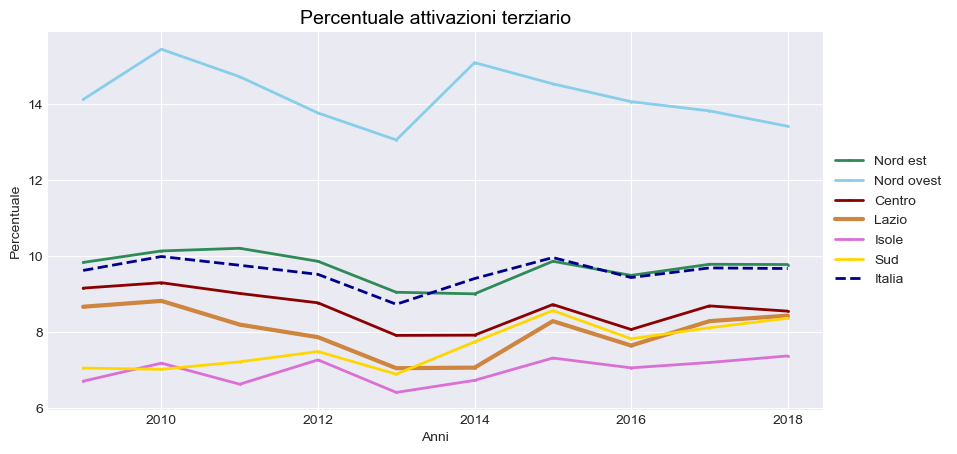

In [50]:
# Plot
# ----
# Style
plt.style.use('seaborn-darkgrid')
my_dpi=100
plt.figure(figsize=(1000/my_dpi, 500/my_dpi), dpi=my_dpi)
# Objets
plt.plot('year', 'Nord est',   data=df, marker='.', markerfacecolor='seagreen', markersize=2, color='seagreen', linewidth=2)
plt.plot('year', 'Nord ovest', data=df, marker='.', markerfacecolor='skyblue', markersize=2, color='skyblue', linewidth=2)
plt.plot('year', 'Centro',     data=df, marker='.', markerfacecolor='darkred', markersize=2, color='darkred', linewidth=2)
plt.plot('year', 'Lazio',      data=df, marker='.', markerfacecolor='peru', markersize=2, color='peru', linewidth=3)
plt.plot('year', 'Isole',      data=df, marker='.', markerfacecolor='orchid', markersize=2, color='orchid', linewidth=2)
plt.plot('year', 'Sud',        data=df, marker='.', markerfacecolor='gold', markersize=2, color='gold', linewidth=2)
plt.plot('year', 'Italia',     data=df, linestyle='dashed', color='darkblue', linewidth=2)
# Legend
#plt.legend(loc=0, ncol=4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Titles
plt.title("Percentuale attivazioni terziario", loc='center', fontsize=14, fontweight=0, color='black')
plt.xlabel("Anni")
plt.ylabel("Percentuale")